<a href="https://colab.research.google.com/github/Kristelwen/TM10007_PROJECT/blob/master/brat_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment, data set 1
Kristel Wenink (4450396), Lalot Gunneman (4532155), Marijn van der Graaf (4468708), Tahisa Robles (4531434)

In [255]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/Kristelwen/TM10007_PROJECT

# Data loading and importing modules

In [0]:
# Importing modules
# General packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from time import time
from scipy.stats import randint

# Preprocessing packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler

# Feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# SVM Kernels
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.decomposition import KernelPCA

# Model selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit

# Performance metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

In [257]:
# Loading the data
from brats.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}\n')
data.groupby('label').size()


The number of samples: 167
The number of columns: 725



label
GBM    102
LGG     65
dtype: int64

In [258]:
# Display data for analysis
data_top = data.head()
data_top 

,VOLUME_ET,VOLUME_NET,VOLUME_ED,VOLUME_TC,VOLUME_WT,VOLUME_BRAIN,VOLUME_ET_OVER_NET,VOLUME_ET_OVER_ED,VOLUME_NET_OVER_ED,VOLUME_ET_over_TC,VOLUME_NET_over_TC,VOLUME_ED_over_TC,VOLUME_ET_OVER_WT,VOLUME_NET_OVER_WT,VOLUME_ED_OVER_WT,VOLUME_TC_OVER_WT,VOLUME_ET_OVER_BRAIN,VOLUME_NET_OVER_BRAIN,VOLUME_ED_over_BRAIN,VOLUME_TC_over_BRAIN,VOLUME_WT_OVER_BRAIN,DIST_Vent_TC,DIST_Vent_ED,INTENSITY_Mean_ET_T1Gd,INTENSITY_STD_ET_T1Gd,INTENSITY_Mean_ET_T1,INTENSITY_STD_ET_T1,INTENSITY_Mean_ET_T2,INTENSITY_STD_ET_T2,INTENSITY_Mean_ET_FLAIR,INTENSITY_STD_ET_FLAIR,INTENSITY_Mean_NET_T1Gd,INTENSITY_STD_NET_T1Gd,INTENSITY_Mean_NET_T1,INTENSITY_STD_NET_T1,INTENSITY_Mean_NET_T2,INTENSITY_STD_NET_T2,INTENSITY_Mean_NET_FLAIR,INTENSITY_STD_NET_FLAIR,INTENSITY_Mean_ED_T1Gd,...,TEXTURE_NGTDM_NET_T1_Busyness,TEXTURE_NGTDM_NET_T1_Complexity,TEXTURE_NGTDM_NET_T1_Strength,TEXTURE_NGTDM_NET_T2_Coarseness,TEXTURE_NGTDM_NET_T2_Contrast,TEXTURE_NGTDM_NET_T2_Busyness,TEXTURE_NGTDM_NET_T2_Complexity,TEXTURE_NGTDM_NET_T2_Strength,TEXTURE_NGTDM_NET_FLAIR_Coarseness,TEXTURE_NGTDM_NET_FLAIR_Contrast,TEXTURE_NGTDM_NET_FLAIR_Busyness,TEXTURE_NGTDM_NET_FLAIR_Complexity,TEXTURE_NGTDM_NET_FLAIR_Strength,TGM_p1,TGM_dw,TGM_Cog_X_1,TGM_Cog_Y_1,TGM_Cog_Z_1,TGM_T_1,TGM_Cog_X_2,TGM_Cog_Y_2,TGM_Cog_Z_2,TGM_T_2,TGM_Cog_X_3,TGM_Cog_Y_3,TGM_Cog_Z_3,TGM_T_3,TGM_Cog_X_4,TGM_Cog_Y_4,TGM_Cog_Z_4,TGM_T_4,TGM_Cog_X_5,TGM_Cog_Y_5,TGM_Cog_Z_5,TGM_T_5,TGM_Cog_X_6,TGM_Cog_Y_6,TGM_Cog_Z_6,TGM_T_6,label
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0006,1662,384,36268,2046,38314,1469432,4.328125,0.0458255,0.0105878,0.81232,0.18768,17.7263,0.043378,0.010022,0.946599,0.053401,0.001131,0.000261,0.024682,0.001392,0.026074,31.5903,2.7735,149.7977,10.4671,194.1422,15.1037,154.9225,43.4709,220.5894,30.2917,137.8881,6.3820,183.6933,14.8846,161.1005,35.8591,227.7510,23.9509,131.8402,...,0.02674,2536.7559,43.3129,0.036634,0.50304,0.024264,3593.3279,43.67590,0.057204,0.33980,0.021897,2203.2034,61.3293,8.00000,7.500000e-07,0.178609,0.096256,0.052741,2.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GBM
TCGA-02-0009,4362,4349,15723,8711,24434,1295721,1.002989,0.277428,0.276601,0.50075,0.49925,1.8050,0.178522,0.177990,0.643489,0.356511,0.003366,0.003356,0.012135,0.006723,0.018857,9.2443,3.0207,165.4345,6.4047,201.2400,13.4733,113.1601,10.1373,210.1810,15.9543,152.6013,4.2360,188.0607,11.1316,116.8538,10.0992,209.7901,16.7943,139.2815,...,0.31558,967.7845,3.7444,0.003790,0.36163,0.271420,1996.1440,2.77050,0.004966,0.28715,0.189980,1440.4285,3.5999,3.31250,1.000000e-09,0.077618,0.122900,0.094336,91.4736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GBM
TCGA-02-0011,33404,48612,45798,82016,127814,1425843,0.687155,0.729377,1.06144,0.40729,0.59271,0.5584,0.261349,0.380334,0.358318,0.641682,0.023428,0.034094,0.032120,0.057521,0.089641,1.0000,1.0000,186.3385,17.6126,188.2019,23.5195,172.8969,32.7401,167.1395,34.1684,149.0643,12.9090,158.4197,15.2632,197.4966,27.1781,165.1014,25.2120,161.5790,...,1.39580,1322.6082,0.7473,0.000634,0.31856,1.144300,2517.8629,0.84294,0.000794,0.17961,1.068800,1147.5177,0.8048,5.78125,1.000000e-09,0.132283,0.116006,0.096035,272.4290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GBM
TCGA-02-0027,12114,7587,34086,19701,53787,1403429,1.596679,0.355395,0.222584,0.61489,0.38511,1.7302,0.225222,0.141056,0.633722,0.366278,0.008632,0.005406,0.024288,0.014038,0.038325,1.0331,1.0000,178.6925,23.1751,199.7626,27.0047,157.0192,25.6793,173.6525,26.3596,120.3726,17.5926,199.5765,25.3652,194.2708,24.5411,207.5531,32.7868,129.2927,...,0.14356,1722.6804,6.9449,0.002126,0.54383,0.379490,3698.6228,2.31820,0.003284,0.41179,0.206600,3320.1690,4.7336,3.87500,1.000000e-09,0.100415,0.088249,0.096470,128.4680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GBM
TCGA-02-0033,34538,7137,65653,41675,107328,1365237,4.839288,0.526069,

# Preprocessing

In [259]:
# Drop columns which contain NaN values
threshold = math.floor(len(data)/2)  # Calculate threshold, half of total rows
data_drop = data.dropna(thresh=threshold, axis=1)  # Delete columns/features with more than 'threshold' NaNs
data_drop = data_drop.fillna(data_drop.median())  # Replace the remaining NaNs with median of feature

data_drop.isnull().values.any()  # Check if all the NaNs are deleted or replaced (False = there are no NaNs left)

False

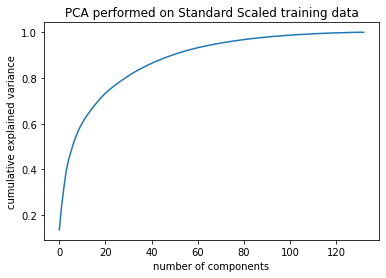

In [260]:
# Split data and labels
labels = data_drop['label']
data_drop = data_drop.drop(columns="label")  # Data without labels

# Convert labels 'GBM' and 'LGG' to respectively 0 and 1
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Replace strings and infinity values with median of feature
data_no_strings = data_drop.replace('#DIV/0!', np.nan)
data_no_strings = data_no_strings.replace([np.inf, -np.inf], np.nan)
data_no_strings = data_no_strings.fillna(data_no_strings.median())

# Split the data in a train (80%) and test set (20%)
data_train, data_test, label_train, label_test = train_test_split(data_no_strings, labels, test_size=0.2, stratify=labels)

# Feature scaling - 2 options to compare
  # Option 1: StandardScaler -> scaling method that is chosen to scale the data with.
scaler = StandardScaler()
transformer = scaler.fit(data_train.values)
data_scaled_train = transformer.transform(data_train.values)
data_df_train = pd.DataFrame(data_scaled_train, index = data_train.index, columns = data_train.columns)

data_scaled_test = transformer.transform(data_test.values)
data_df_test = pd.DataFrame(data_scaled_test, index = data_test.index, columns = data_test.columns)

# PCA with Standard Scaled data 
pca_plot = PCA().fit(data_df_train)
plt.plot(np.cumsum(pca_plot.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA performed on Standard Scaled training data')
  # Training set
pca_train = PCA(0.95)
pca_train.fit(data_df_train)
data_train_pca = pca_train.transform(data_df_train)
  # Test set
data_test_pca = pca_train.transform(data_df_test)



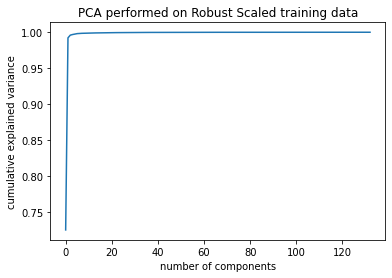

In [261]:
# Feature scaling - 2 options to compare
  # Option 2: RobustScaler -> Not chosen and thus not used to scale the data
scaler2 = RobustScaler()
transformer2 = scaler2.fit(data_train.values)
data_scaled_train2 = transformer2.transform(data_train.values)
data_df_train2 = pd.DataFrame(data_scaled_train2, index = data_train.index, columns = data_train.columns)

# PCA with Robust Scaled data
pca_plot2 = PCA().fit(data_df_train2)
plt.plot(np.cumsum(pca_plot2.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('PCA performed on Robust Scaled training data')
  # Training set
pca_train2 = PCA(0.95)
pca_train2.fit(data_df_train2)
data_train_pca2 = pca_train2.transform(data_df_train2)

# Visualising the training set

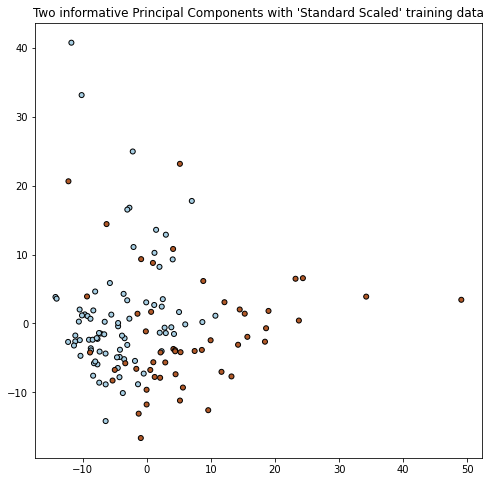

In [266]:
# Visualising the Standard Scaled trainingsdata with the first 2 Principal Components
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title("Two informative Principal Components with 'Standard Scaled' training data",
             fontsize='large')
ax.scatter(data_train_pca[:, 0], data_train_pca[:, 1], marker='o', c=label_train,
           s=25, edgecolor='k', cmap=plt.cm.Paired)

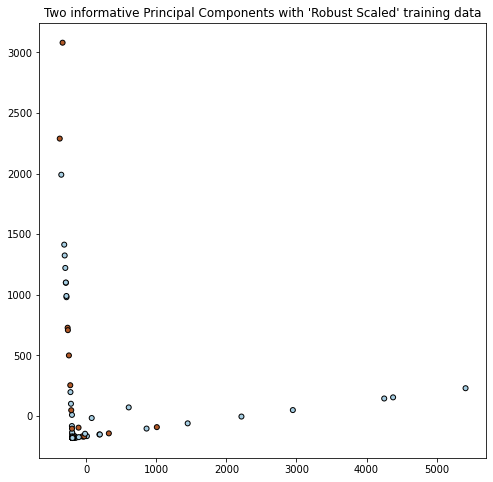

In [267]:
# Visualising the Robust Scaled trainingsdata with the first 2 Principal Components
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title("Two informative Principal Components with 'Robust Scaled' training data",
             fontsize='large')
ax.scatter(data_train_pca2[:, 0], data_train_pca2[:, 1], marker='o', c=label_train,
           s=25, edgecolor='k', cmap=plt.cm.Paired)

# Classifiers

## k-Nearest-Neighbors

### k-NN with PCA

In [0]:
# Using different n_neighbors with weights = 'distance'
print('Results when weights are based on distance:')
n_neighbors=[1,5,7,10,11,15,20,50,100]
for n_neighbor in n_neighbors:
  clf = KNeighborsClassifier(n_neighbors=n_neighbor, weights='distance')
  clf.fit(data_train_pca, label_train)

  pred_train_knn = clf.predict(data_train_pca)
  acc_train_knn = accuracy_score(label_train, pred_train_knn)
  print ('Train set: {} neighbors gives an accuracy of {}'.format(n_neighbor, round(acc_train_knn,2)))

  pred_test_knn = clf.predict(data_test_pca)
  acc_test_knn = accuracy_score(label_test, pred_test_knn)
  print ('Test set: {} neighbors gives an accuracy of {}'.format(n_neighbor, round(acc_train_knn,2)))

# Using different n_neighbors with weights = 'uniform'
print('\n Results when weights are uniform:')
n_neighbors=[1,5,7,10,11,15,20,50,100]
for n_neighbor in n_neighbors:
  clf = KNeighborsClassifier(n_neighbors=n_neighbor, weights='uniform')
  clf.fit(data_train_pca, label_train)

  pred_train_knn = clf.predict(data_train_pca)
  acc_train_knn = accuracy_score(label_train, pred_train_knn)
  print ('Train set: {} neighbors gives an accuracy of {}'.format(n_neighbor, round(acc_train_knn,2)))
  
  pred_test_knn = clf.predict(data_test_pca)
  acc_test_knn = accuracy_score(label_test, pred_test_knn)
  print ('Test set: {} neighbors gives an accuracy of {}'.format(n_neighbor, round(acc_train_knn,2)))

Results when weights are based on distance:
Train set: 1 neighbors gives an accuracy of 1.0
Test set: 1 neighbors gives an accuracy of 1.0
Train set: 5 neighbors gives an accuracy of 1.0
Test set: 5 neighbors gives an accuracy of 1.0
Train set: 7 neighbors gives an accuracy of 1.0
Test set: 7 neighbors gives an accuracy of 1.0
Train set: 10 neighbors gives an accuracy of 1.0
Test set: 10 neighbors gives an accuracy of 1.0
Train set: 11 neighbors gives an accuracy of 1.0
Test set: 11 neighbors gives an accuracy of 1.0
Train set: 15 neighbors gives an accuracy of 1.0
Test set: 15 neighbors gives an accuracy of 1.0
Train set: 20 neighbors gives an accuracy of 1.0
Test set: 20 neighbors gives an accuracy of 1.0
Train set: 50 neighbors gives an accuracy of 1.0
Test set: 50 neighbors gives an accuracy of 1.0
Train set: 100 neighbors gives an accuracy of 1.0
Test set: 100 neighbors gives an accuracy of 1.0

 Results when weights are uniform:
Train set: 1 neighbors gives an accuracy of 1.0
Tes

In [0]:
# Hyperparameter optimization of number of neighbors and weights with PCA

# Parameter distributions, to optimize the number of neighbors and the weights
param_distributions = {'n_neighbors': [1,5,7,10,11,15,20,50,100], 'weights': ['uniform','distance']} 
    
# Execute RandomizedSearchCV to find optimal parameters
clf_knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions, scoring='accuracy', cv=5, return_train_score=True)

# Fit the classifier
clf_knn.fit(data_train_pca, label_train)

# The best parameters
print(f'The best parameters are {clf_knn.best_params_} with a mean accuracy of {clf_knn.best_score_}')

pd.DataFrame(clf_knn.cv_results_)


The best parameters are {'weights': 'distance', 'n_neighbors': 10} with a mean accuracy of 0.8128205128205128


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.000982,0.000314,0.001798,0.000140,distance,10,"{'weights': 'distance', 'n_neighbors': 10}",0.703704,0.814815,0.814815,0.884615,0.846154,0.812821,0.060299,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.000899,0.000198,0.002651,0.000356,uniform,10,"{'weights': 'uniform', 'n_neighbors': 10}",0.703704,0.814815,0.814815,0.884615,0.807692,0.805128,0.057964,2,0.849057,0.820755,0.858491,0.822430,0.850467,0.840240,0.015571
2,0.000589,0.000020,0.001408,0.000032,distance,50,"{'weights': 'distance', 'n_neighbors': 50}",0.629630,0.703704,0.592593,0.807692,0.615385,0.669801,0.078357,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.000606,0.000027,0.001963,0.000039,uniform,20,"{'weights': 'uniform', 'n_neighbors': 20}",0.629630,0.814815,0.703704,0.884615,0.769231,0.760399,0.088072,6,0.820755,0.820755,0.830189,0.775701,0.831776,0.815835,0.020588
4,0.000454,0.000039,0.001558,0.000137,distance,100,"{'weights': 'distance', 'n_neighbors': 100}",0.629630,0.592593,0.592593,0.615385,0.615385,0.609117,0.014460,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.000807,0.000017,0.001632,0.000103,distance,1,"{'weights': 'distance', 'n_neighbors': 1}",0.666667,0.777778,0.777778,0.692308,0.807692,0.744444,0.054754,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,0.000793,0.000009,0.001619,0.000012,distance,7,"{'weights': 'distance', 'n_neighbors': 7}",0.703704,0.740741,0.740741,0.961538,0.846154,0.798575,0.094351,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,0.000814,0.000029,0.001682,0.000044,distance,15,"{'weights': 'distance', 'n_neighbors': 15}",0.666667,0.814815,0.814815,0.884615,0.807692,0.797721,0.071288,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,0.000506,0.000027,0.002643,0.000043,uniform,100,"{'weights': 'uniform', 'n_neighbors': 100}",0.629630,0.592593,0.592593,0.615385,0.615385,0.609117,0.014460,9,0.603774,0.613208,0.613208,0.607477,0.607477,0.609028,0.003670
9,0.000813,0.000030,0.001851,0.000090,distance,20,"{'weights': 'distance', 'n_neighbors': 20}",0.592593,0.814815,0.740741,0.961538,0.769231,0.775783,0.119045,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [0]:
# Fitting the K-NN Classifier
KNN = KNeighborsClassifier(n_neighbors=5, weights='uniform')
KNN.fit(data_train_pca, label_train)

# Predictions
train_pred_knn = KNN.predict(data_train_pca)

In [0]:
# Evaluate KNN using cross-validation
score_knn = cross_val_score(KNN, data_train_pca, label_train, cv=5)
mean_score_knn = score_knn.mean()

print(f'The accuracy of the validation set in 5 different folds is {score_knn}')
print(f'\n The mean accuracy of the validation set of 5 different folds is {round(mean_score_knn,2)}')

# Evaluate accuracy of KNN on training set
acc_train_knn = accuracy_score(label_train, train_pred_knn)
print(f'\n The accuracy of the training set is {round(acc_train_knn,2)}')

The accuracy of the validation set in 5 different folds is [0.74074074 0.81481481 0.81481481 0.92307692 0.84615385]

 The mean accuracy of the validation set of 5 different folds is 0.83

 The accuracy of the training set is 0.89


In [0]:
# Confusion matrices and classification reports of trainings data
print('Confusion matrix and classification report of training set')
print(confusion_matrix(label_train, train_pred_knn))
print(classification_report(label_train, train_pred_knn))

Confusion matrix and classification report of training set
[[76  5]
 [ 9 43]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        81
           1       0.90      0.83      0.86        52

    accuracy                           0.89       133
   macro avg       0.89      0.88      0.89       133
weighted avg       0.89      0.89      0.89       133



## Random Forest Classifier

### Random Forest with PCA

In [0]:
# Hyperparameter optimization: trying out different amount of trees and compare bootstrapping True and False.

#using different n_trees and bootstrapping  
print('Results when bootstrapping=True')
n_trees=[1,5,10,15,20,30,50,100,150,200]
for n_tree in n_trees:
  clf = RandomForestClassifier(n_estimators=n_tree, bootstrap=True)
  clf.fit(data_train_pca,label_train)
  
  predictions_train = clf.predict(data_train_pca)
  acc_train_RF = accuracy_score(label_train, predictions_train)
  
  print ('Train set: {} trees gives an accuracy of {}'.format(n_tree, round(acc_train_RF,2)))

  predictions_test = clf.predict(data_test_pca)
  acc_test_RF = accuracy_score(label_test, predictions_test)

  print ('Test set: {} trees gives an accuracy of {}'.format(n_tree, round(acc_test_RF, 2)))

print ('')

#using different n_trees without bootstrapping 
print('Results when bootstrapping=False')
for n_tree in n_trees:
  clf = RandomForestClassifier(n_estimators=n_tree, bootstrap=False)
  clf.fit(data_train_pca,label_train)
  
  predictions_train = clf.predict(data_train_pca)
  acc_train_RF = accuracy_score(label_train, predictions_train)
  print ('Train set: {} trees gives an accuracy of {}'.format(n_tree,round(acc_train_RF,2)))

  predictions_test = clf.predict(data_test_pca)
  acc_test_RF = accuracy_score(label_test, predictions_test)

  print ('Test set: {} trees gives an accuracy of {}'.format(n_tree,round(acc_test_RF,2)))

Results when bootstrapping=True
Train set: 1 trees gives an accuracy of 0.88
Test set: 1 trees gives an accuracy of 0.65
Train set: 5 trees gives an accuracy of 0.98
Test set: 5 trees gives an accuracy of 0.74
Train set: 10 trees gives an accuracy of 0.98
Test set: 10 trees gives an accuracy of 0.79
Train set: 15 trees gives an accuracy of 1.0
Test set: 15 trees gives an accuracy of 0.65
Train set: 20 trees gives an accuracy of 1.0
Test set: 20 trees gives an accuracy of 0.82
Train set: 30 trees gives an accuracy of 1.0
Test set: 30 trees gives an accuracy of 0.74
Train set: 50 trees gives an accuracy of 1.0
Test set: 50 trees gives an accuracy of 0.74
Train set: 100 trees gives an accuracy of 1.0
Test set: 100 trees gives an accuracy of 0.91
Train set: 150 trees gives an accuracy of 1.0
Test set: 150 trees gives an accuracy of 0.82
Train set: 200 trees gives an accuracy of 1.0
Test set: 200 trees gives an accuracy of 0.79

Results when bootstrapping=False
Train set: 1 trees gives an a

In [0]:
# Hyperparameter optimization of Random Forest Classifier with PCA

# Parameter distributions, to optimize the number of estimators, max features and max depth 
param_distributions = {'n_estimators': [1,5,10,15,20,30,50,100,150,200],
                       'max_features': list(range(10,len(data_train_pca[1]),10)),
                       'max_depth': list(range(10,50,10))} 
                        
# Execute RandomizedSearchCV to find optimal parameters
clf_rf = RandomizedSearchCV(RandomForestClassifier(bootstrap=True), param_distributions, scoring='accuracy', cv=5, return_train_score=True)

# Fit the classifier
clf_rf.fit(data_train_pca, label_train)

# The best parameters
print(f'The best parameters are {clf_rf.best_params_} with a mean accuracy of {clf_rf.best_score_}')


The best parameters are {'n_estimators': 200, 'max_features': 30, 'max_depth': 20} with a mean accuracy of 0.805982905982906


In [0]:
# Fitting the Random Forest classifier with PCA
RF = RandomForestClassifier(n_estimators=50, max_features=40, max_depth=40, bootstrap=True)
RF.fit(data_train_pca, label_train)

# Predictions
train_pred_RF = RF.predict(data_train_pca)


In [0]:
# Evaluate Random Forest using cross-validation
score_rf = cross_val_score(RF, data_train_pca, label_train, cv=5)
mean_score_rf = score_rf.mean()

print(f'\n The accuracy of the validation set in 5 different folds is {score_rf}')
print(f'\n The mean accuracy of the validation set of 5 different folds is {round(mean_score_rf,2)}')

# Evaluate accuracy of Random Forest Classifier on training set
acc_train_RF = accuracy_score(label_train, train_pred_RF)
print(f'\n The accuracy on the training set is {round(acc_train_RF, 2)}')


 The accuracy of the validation set in 5 different folds is [0.7037037  0.7037037  0.74074074 0.88461538 0.80769231]

 The mean accuracy of the validation set of 5 different folds is 0.77

 The accuracy on the training set is 1.0


In [0]:
# Confusion matrices and classification reports of trainings data
print('Confusion matrix and classification report of training set')
print(confusion_matrix(label_train, train_pred_RF))
print(classification_report(label_train, train_pred_RF))

Confusion matrix and classification report of training set
[[81  0]
 [ 0 52]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        81
           1       1.00      1.00      1.00        52

    accuracy                           1.00       133
   macro avg       1.00      1.00      1.00       133
weighted avg       1.00      1.00      1.00       133



### Random Forest with Feature Importances

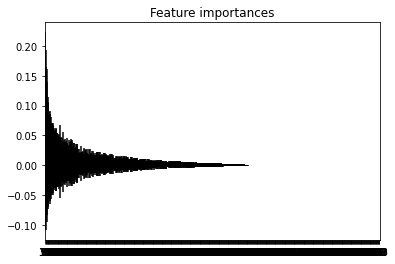

In [0]:
# Feature_Importances
estimator_fi = RandomForestClassifier()
estimator_fi.fit(data_df_train, label_train)
importances = estimator_fi.feature_importances_
std = np.std([tree.feature_importances_ for tree in estimator_fi.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
# print("Feature ranking:")

# for f in range(data_df_train.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data_df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data_df_train.shape[1]), indices)
plt.xlim([-1, data_df_train.shape[1]])
plt.show()

# Only keep features with importance > 0.001
  # Training set
mask = importances > 0.001
mask2 = data_df_train.columns[mask]
data_train_selection = data_df_train[mask2]
  # Test set
data_test_selection = data_df_test[mask2]


In [0]:
# Hyperparameter optimization of Random Forest with 'Feature Importances'

# Execute RandomizedSearchCV to find optimal parameters
clf_fi = RandomizedSearchCV(estimator_fi, param_distributions, scoring='accuracy', cv=5, return_train_score=True)

# Fit the classifier
clf_fi.fit(data_train_selection, label_train)

# The best parameters
print(f'The best parameters are {clf_fi.best_params_} with a mean accuracy of {clf_fi.best_score_}')

The best parameters are {'n_estimators': 100, 'max_features': 10, 'max_depth': 40} with a mean accuracy of 0.9176638176638177


In [0]:
# Fit the classifier on the selected features
FI = RandomForestClassifier(n_estimators=10, max_features=60, max_depth=10, bootstrap=True)
FI.fit(data_train_selection, label_train)

# Predictions
train_pred_fi = FI.predict(data_train_selection)

In [0]:
# Evaluate Random Forest using cross-validation
score_fi = cross_val_score(FI, data_train_selection, label_train, cv=5)
mean_score_fi = score_fi.mean()

print(f'\n The accuracy of the validation set in 5 different folds is {score_fi}')
print(f'\n The mean accuracy of the validation set of 5 different folds is {round(mean_score_fi,2)}')

# Evaluate accuracy of Random Forest Classifier on training set
acc_train_fi = accuracy_score(label_train, train_pred_fi)
print(f'\n The accuracy on the training set is {round(acc_train_fi, 2)}')


 The accuracy of the validation set in 5 different folds is [0.81481481 1.         0.88888889 0.92307692 0.92307692]

 The mean accuracy of the validation set of 5 different folds is 0.91

 The accuracy on the training set is 0.99


In [0]:
# Confusion matrices and classification reports of trainings data
print('Confusion matrix and classification report of training set')
print(confusion_matrix(label_train, train_pred_fi))
print(classification_report(label_train, train_pred_fi))

Confusion matrix and classification report of training set
[[81  0]
 [ 1 51]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        81
           1       1.00      0.98      0.99        52

    accuracy                           0.99       133
   macro avg       0.99      0.99      0.99       133
weighted avg       0.99      0.99      0.99       133



## Support Vector Machine

### SVM with PCA 

In [0]:
# Hyperparameter optimization of SVM with PCA

# Parameter distributions, to optimize the degree, coef0, slack, gamma and the kernel
degrees = [1, 3, 5]
coef0s = [1, 0.5, 0.01]
slacks = [0.1, 1, 10, 100]
gammas = [1, 0.1 ,0.01, 0.001]
kernels = ['linear', 'rbf', 'poly']

# Creating paramater space
param_grid = {'degree': degrees,'coef0': coef0s, 'C': slacks, 'gamma': gammas, 'kernel': kernels}

# Execute RandomizedSearchCV to find optimal parameters
clf_svm = RandomizedSearchCV(SVC(),param_grid, scoring='accuracy', cv=5, return_train_score=True)

# Fit the classifier
clf_svm.fit(data_train_pca, label_train)

# The best parameters
print(f'The best parameters are {clf_svm.best_params_} with a mean accuracy of {clf_svm.best_score_}')


The best parameters are {'kernel': 'poly', 'gamma': 1, 'degree': 3, 'coef0': 1, 'C': 100} with a mean accuracy of 0.8578347578347578


In [0]:
# Fitting the Support Vector Machine classifier
SVM = SVC(C=10, kernel='linear', degree=1, gamma=0.001, coef0=0.01)
SVM.fit(data_train_pca, label_train)

# Predictions
train_pred_svm = SVM.predict(data_train_pca)

In [0]:
# Evaluate the SVM classifier using cross-validation
score_svm = cross_val_score(SVM, data_train_pca, label_train, cv=5)
mean_score_svm = score_svm.mean()

print(f'The accuracy of the validation set in 5 different folds is {score_svm}')
print(f'\n The mean accuracy of the validation set of 5 different folds is {round(mean_score_svm,2)}')

# Evaluate accuracy of SVM on training set
acc_train_svm = accuracy_score(label_train, train_pred_svm)
print(f'\n The accuracy of the training set is {round(acc_train_svm,2)}')


The accuracy of the validation set in 5 different folds is [0.7037037  0.81481481 0.81481481 0.92307692 0.88461538]

 The mean accuracy of the validation set of 5 different folds is 0.83

 The accuracy of the training set is 1.0


In [0]:
# Confusion matrix and classification reports of trainings data
print('Confusion matrix and classification report of training set')
print(confusion_matrix(label_train, train_pred_svm))
print(classification_report(label_train, train_pred_svm))

Confusion matrix and classification report of training set
[[81  0]
 [ 0 52]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        81
           1       1.00      1.00      1.00        52

    accuracy                           1.00       133
   macro avg       1.00      1.00      1.00       133
weighted avg       1.00      1.00      1.00       133



### SVM with RFECV

In [0]:
# RFECV
estimator = SVC(kernel='linear')
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(data_df_train, label_train)
mask = selector.support_
RFECV_columns = data_df_train.columns[mask]

# Feature selection
  # Training set
data_train_RFECV = data_df_train[RFECV_columns]
  # Test set
data_test_RFECV = data_df_test[RFECV_columns]

In [0]:
# Hyperparameter optimization of SVM with RFECV

# Execute RandomizedSearchCV to find optimal parameters
clf_svmlin = RandomizedSearchCV(estimator, param_grid, scoring='accuracy', cv=5, return_train_score=True)

# Fit the classifier
clf_svmlin.fit(data_train_RFECV, label_train)

# The best parameters
print(f'The best parameters are {clf_svmlin.best_params_} with a mean accuracy of {clf_svmlin.best_score_}')


The best parameters are {'kernel': 'linear', 'gamma': 0.1, 'degree': 5, 'coef0': 0.01, 'C': 100} with a mean accuracy of 0.9772079772079773


In [0]:
# Fit the classifier on the selected features
SVMLIN = SVC(C=0.1, kernel='linear', degree=1, gamma=1, coef0=0.5)
SVMLIN.fit(data_train_RFECV, label_train)

# Predictions
train_pred_rfecv = SVMLIN.predict(data_train_RFECV)

In [0]:
# Evaluate SVM using cross-validation
score_rfecv = cross_val_score(SVMLIN, data_train_RFECV, label_train, cv=5)
mean_score_rfecv = score_rfecv.mean()

print(f'\n The accuracy of the validation set in 5 different folds is {score_rfecv}')
print(f'\n The mean accuracy of the validation set of 5 different folds is {round(mean_score_rfecv,2)}')

# Evaluate accuracy of SVM on training set
acc_train_rfecv = accuracy_score(label_train, train_pred_rfecv)
print(f'\n The accuracy on the training set is {round(acc_train_rfecv, 2)}')


 The accuracy of the validation set in 5 different folds is [0.92592593 1.         0.96296296 1.         1.        ]

 The mean accuracy of the validation set of 5 different folds is 0.98

 The accuracy on the training set is 0.99


In [0]:
# Confusion matrices and classification reports of trainings data
print('Confusion matrix and classification report of training set')
print(confusion_matrix(label_train, train_pred_rfecv))
print(classification_report(label_train, train_pred_rfecv))

Confusion matrix and classification report of training set
[[81  0]
 [ 1 51]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        81
           1       1.00      0.98      0.99        52

    accuracy                           0.99       133
   macro avg       0.99      0.99      0.99       133
weighted avg       0.99      0.99      0.99       133



## Neural Networks

In [0]:
# Hyperparameter optimization of Neural Network with PCA

# Parameter distributions, to optimize the hidden layer sizes, alpha and the learning rate
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (7,2), (7,7,7),(9,9,9,9),(50,50,50,50), (50,50,50,50,50)],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
    
# Execute RandomizedSearchCV to find optimal parameters
clf_mlp = RandomizedSearchCV(MLPClassifier(solver='lbfgs', max_iter=8000), parameter_space, scoring='accuracy', cv=5, return_train_score=True)  # Verbose=2 & refit=True uitzoeken

# Fit the classifier
clf_mlp.fit(data_train_pca, label_train)

# The best parameters
print(f'The best parameters are {clf_mlp.best_params_} with a mean accuracy of {clf_mlp.best_score_}')

The best parameters are {'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001} with a mean accuracy of 0.8729344729344728


In [0]:
# Fitting the Neural Network Classifier with optimal hyperparameters
MLP = MLPClassifier(solver='lbfgs', learning_rate='constant',hidden_layer_sizes=(100,), alpha=0.05, activation='relu', max_iter=1000)
MLP.fit(data_train_pca, label_train)

# Predictions
train_pred_MLP = MLP.predict(data_train_pca)


In [0]:
# Evaluate neural network using cross-validation
score = cross_val_score(MLP, data_train_pca, label_train, cv=5)
mean_score = score.mean()

print(f'\n The accuracy of the validation set in 5 different folds is {score}')
print(f'\n The mean accuracy of the validation set of 5 different folds is {round(mean_score,2)}')

# Evaluate accuracy of neural network on training set
acc_train_MLP = accuracy_score(label_train, train_pred_MLP)
print(f'\n The accuracy of the training set is {round(acc_train_MLP,2)}')


 The accuracy of the validation set in 5 different folds is [0.77777778 0.88888889 0.85185185 0.96153846 0.88461538]

 The mean accuracy of the validation set of 5 different folds is 0.87

 The accuracy of the training set is 1.0


In [0]:
# Confusion matrices and classification reports of training data
print('Confusion matrix and classification report of training set')
print(confusion_matrix(label_train, train_pred_MLP))
print(classification_report(label_train, train_pred_MLP))

Confusion matrix and classification report of training set
[[81  0]
 [ 0 52]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        81
           1       1.00      1.00      1.00        52

    accuracy                           1.00       133
   macro avg       1.00      1.00      1.00       133
weighted avg       1.00      1.00      1.00       133



# Evaluation

## Accuracies on test data

In [0]:
# K-NN with PCA - evaluation

# Evaluate accuracy of KNN on test set
test_pred_knn = KNN.predict(data_test_pca)
acc_test_knn = accuracy_score(label_test, test_pred_knn)
print(f'\n The accuracy of the test set is {round(acc_test_knn,2)}')

# Confusion matrices and classification reports of test data
print('Confusion matrix and classification report of test set')
print(confusion_matrix(label_test, test_pred_knn))
print(classification_report(label_test, test_pred_knn))


 The accuracy of the test set is 0.88
Confusion matrix and classification report of test set
[[19  2]
 [ 2 11]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       0.85      0.85      0.85        13

    accuracy                           0.88        34
   macro avg       0.88      0.88      0.88        34
weighted avg       0.88      0.88      0.88        34



In [0]:
# Random Forest with 'Feature Importances' - evaluation

# Evaluate accuracy of Random Forest Classifier on test set
test_pred_fi = FI.predict(data_test_selection)
acc_test_fi = accuracy_score(label_test, test_pred_fi)
print(f'\n The accuracy on the test set is {round(acc_test_fi, 2)}')

# Confusion matrices and classification reports of test data
print('Confusion matrix and classification report of test set')
print(confusion_matrix(label_test, test_pred_fi))
print(classification_report(label_test, test_pred_fi))


 The accuracy on the test set is 0.85
Confusion matrix and classification report of test set
[[18  3]
 [ 2 11]]
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.79      0.85      0.81        13

    accuracy                           0.85        34
   macro avg       0.84      0.85      0.85        34
weighted avg       0.86      0.85      0.85        34



In [0]:
# SVM with RFECV - evaluation

# Evaluate accuracy of SVM on test set
test_pred_rfecv = SVMLIN.predict(data_test_RFECV)
acc_test_rfecv = accuracy_score(label_test, test_pred_rfecv)
print(f'\n The accuracy of the test set is {round(acc_test_rfecv,2)}')

# Confusion matrices and classification reports of test data
print('Confusion matrix and classification report of test set')
print(confusion_matrix(label_test, test_pred_rfecv))
print(classification_report(label_test, test_pred_rfecv))


 The accuracy of the test set is 0.82
Confusion matrix and classification report of test set
[[17  4]
 [ 2 11]]
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        21
           1       0.73      0.85      0.79        13

    accuracy                           0.82        34
   macro avg       0.81      0.83      0.82        34
weighted avg       0.83      0.82      0.83        34



In [0]:
# Neural Network with PCA - evaluation

# Evaluate accuracy of Neural Network on test set
test_pred_MLP = MLP.predict(data_test_pca)
acc_test_MLP = accuracy_score(label_test, test_pred_MLP)
print(f'\n The accuracy of the test set is {round(acc_test_MLP,2)}')

# Confusion matrices and classification reports of test data
print('Confusion matrix and classification report of test set')
print(confusion_matrix(label_test, test_pred_MLP))
print(classification_report(label_test, test_pred_MLP))


 The accuracy of the test set is 0.88
Confusion matrix and classification report of test set
[[19  2]
 [ 2 11]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       0.85      0.85      0.85        13

    accuracy                           0.88        34
   macro avg       0.88      0.88      0.88        34
weighted avg       0.88      0.88      0.88        34



## Learning Curves

In [0]:
# Function definition of learning curves
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt


In [0]:
# Learning curves of training data set
# Plot figuren
# fig = plt.figure(figsize=(24,24))
  
# # Create a cross-validation object
# cv = StratifiedShuffleSplit(n_splits=3, test_size=0.15) # test_size=0.15, random_state=0

# # Now use the classifiers on all datasets
# num = 0

# # K-NN with PCA
# ax1 = fig.add_subplot(2,2,1)
# title1 = f"kNN Classifier with PCA, #neighbors = {KNN.n_neighbors}"
# plot_learning_curve(KNN, title1, data_train_pca, label_train, ax1, ylim=(0.3, 1.01), cv=cv)

# # Random Forest with 'Feature Importances'
# ax2 = fig.add_subplot(2,2,2)
# title2 = f"RF Classifier with Feature Importances, #trees = {FI.n_estimators}"
# plot_learning_curve(FI, title2, data_train_selection, label_train, ax2, ylim=(0.3, 1.01), cv=cv)

# # SVM with RFECV
# ax3 = fig.add_subplot(2,2,3)
# title3 = f"SVM Classifier with RFECV, slack = {SVMLIN.C}"
# plot_learning_curve(SVMLIN, title3, data_train_RFECV, label_train, ax3, ylim=(0.3, 1.01), cv=cv)

# # Neural Network with PCA
# ax4 = fig.add_subplot(2,2,4)
# title4 = f"MLP Classifier with PCA, hidden layer sizes = {MLP.hidden_layer_sizes}"
# plot_learning_curve(MLP, title4, data_train_pca, label_train, ax4, ylim=(0.3, 1.01), cv=cv)


In [0]:
# Apply preprocessing to the whole dataset
  # Scaling 
data_scaled = transformer.transform(data_no_strings.values)
data_df = pd.DataFrame(data_scaled, index = data_no_strings.index, columns = data_no_strings.columns)
  # PCA
data_pca = pca_train.transform(data_df)
# RFECV
data_RFECV = data_df[RFECV_columns]
# FI
data_selection = data_df[mask2]

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

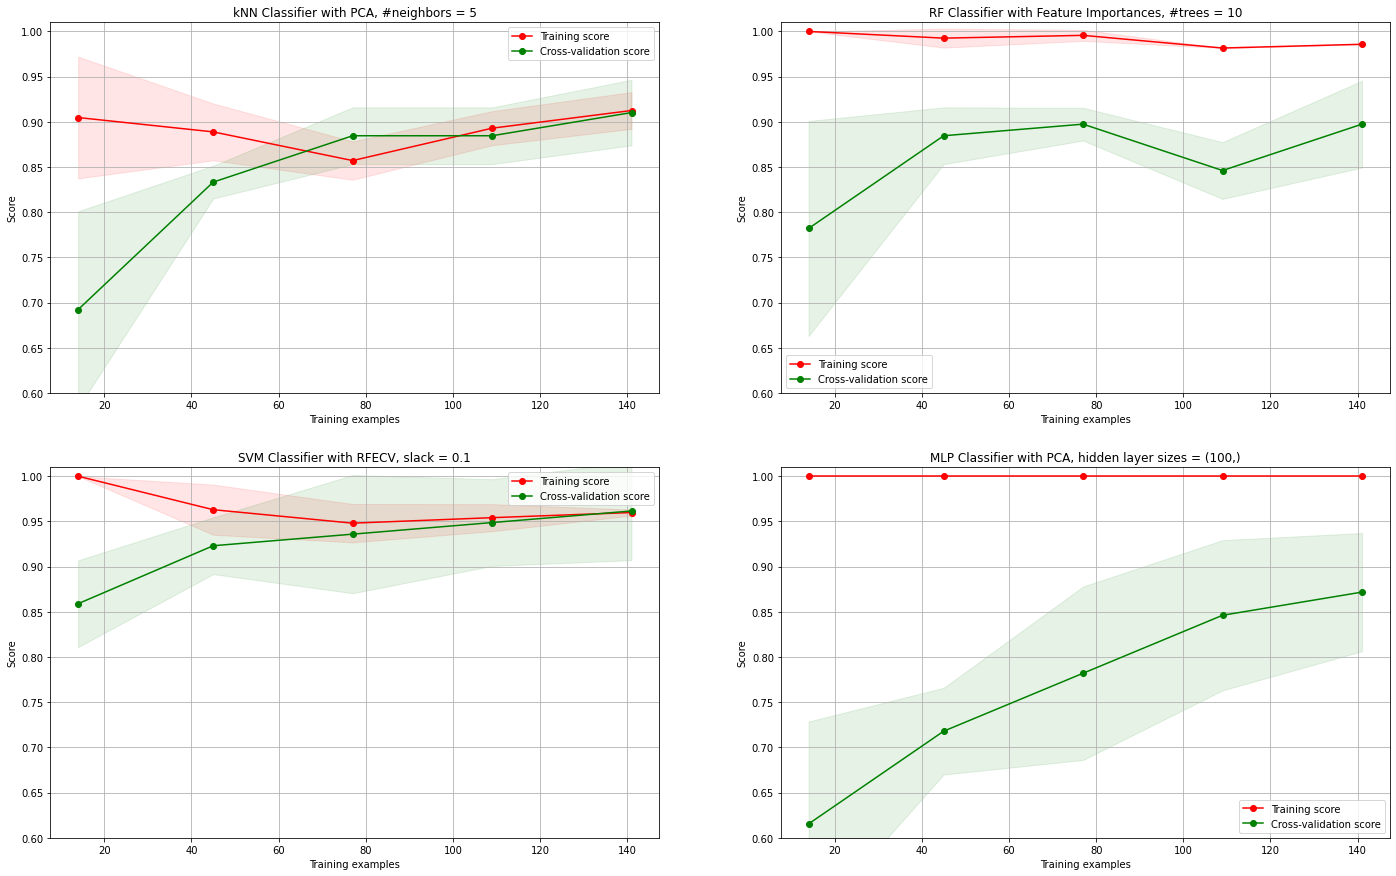

In [0]:
# Learning curves on the whole data set
# Plot figuren
fig = plt.figure(figsize=(24,15))
  
# Create a cross-validation object
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.15)

# Now use the classifiers on all datasets
num = 0

# K-NN with PCA
ax1 = fig.add_subplot(2,2,1)
title1 = f"kNN Classifier with PCA, #neighbors = {KNN.n_neighbors}"
plot_learning_curve(KNN, title1, data_pca, labels, ax1, ylim=(0.6, 1.01), cv=cv)

# Random Forest with 'Feature Importances'
ax2 = fig.add_subplot(2,2,2)
title2 = f"RF Classifier with Feature Importances, #trees = {FI.n_estimators}"
plot_learning_curve(FI, title2, data_selection, labels, ax2, ylim=(0.6, 1.01), cv=cv)

# SVM with RFECV
ax3 = fig.add_subplot(2,2,3)
title3 = f"SVM Classifier with RFECV, slack = {SVMLIN.C}"
plot_learning_curve(SVMLIN, title3, data_RFECV, labels, ax3, ylim=(0.6, 1.01), cv=cv)

# Neural Network with PCA
ax4 = fig.add_subplot(2,2,4)
title4 = f"MLP Classifier with PCA, hidden layer sizes = {MLP.hidden_layer_sizes}"
plot_learning_curve(MLP, title4, data_pca, labels, ax4, ylim=(0.6, 1.01), cv=cv)
